## CBC5 classification
This notebook contains the reclassification of the subtypes of CBC5 based on the density profiles of their axon terminal systems in the IPL. The resulting classification, together with the CBC1/2 classification from the corrigendum of Helmstaedter et al. (2013) is written to a file to be used by all other notebooks

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.spatial import ConvexHull
from PIL import Image
from PIL import ImageDraw
import pandas as pd
import seaborn as sns
from sklearn.mixture import GMM
from sklearn.decomposition import PCA
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})
sns.set_style("whitegrid")
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial']

In [4]:
BC_IDs=np.loadtxt('data/cell_IDs.csv',dtype=int,delimiter=',')
BC_IDs=BC_IDs[(BC_IDs[:,3]>57)&(BC_IDs[:,3]<72)]

In [5]:
#CBC1/2 classification from corrigendum
CBC1=[393,400,403,410,412,414,415,417,418,420,421,422,424,427,430,431,432,433,436,438,440,441,444,445,447,449]
CBC2=[390,391,392,394,395,396,397,398,399,401,402,404,405,406,407,408,409,411,413,416,419,423,425,426,428,429,434,435,437,439,442,443,446,448]
BC_IDs=np.concatenate((BC_IDs,BC_IDs[:,3].reshape(-1,1)),axis=1)
BC_IDs[np.in1d(BC_IDs[:,0],CBC1),4]=58
BC_IDs[np.in1d(BC_IDs[:,0],CBC2),4]=59

In [6]:
skeleton_data=loadmat('data/skeletons_OPL_final.mat')
skeleton_ids=skeleton_data['kn_allSkeletons_e2006_IDs'].flatten()
skeletons=skeleton_data['kn_allSkeletons_e2006'].flatten()
M=np.loadtxt('data/coordinate_rotation')
soma_data=loadmat('data/soma_positions.mat')
soma_pos=soma_data['kn_e2006_ALLSKELETONS_FINAL2012_allSomata']
soma_internal_ids=soma_data['kn_e2006_ALLSKELETONS_FINAL2012_cellIDs']
soma_line_ids=soma_data['kn_e2006_ALLSKELETONS_FINAL2012_cellIDs_pure_forSomata']
soma_pos=np.dot(M,soma_pos[:,:3].T).T
soma_positions=[]
for i in range(BC_IDs.shape[0]):
    soma_positions.append(soma_pos[soma_line_ids[0,np.where(soma_internal_ids==BC_IDs[i,1])[1][0]]-1,:])
soma_positions=np.array(soma_positions)

In [7]:
volume_density=np.loadtxt('data/density_data_BC_flattened.gz')

In [8]:
start_ipl=[]
for i in range(volume_density.shape[1]):
    try:
        start_ipl.append(np.min(np.where(volume_density[:,i]>0)))
    except ValueError:
        continue
end_ipl=[]
for i in range(volume_density.shape[1]):
    try:
        end_ipl.append(np.max(np.where(volume_density[:,i]>0)))
    except ValueError:
        continue
volume_density=volume_density[np.min(start_ipl):np.max(end_ipl),:]

In [9]:
cbc5_volume_density=volume_density[:,(BC_IDs[:,3]>62)&(BC_IDs[:,3]<66)]

In [10]:
cbc5_volume_density2=np.copy(cbc5_volume_density)
cbc5_volume_density2[:1500,:]=0

In [11]:
on_sac_volume_density=np.loadtxt('data/density_data_ON_SAC_flattened.gz')
off_sac_volume_density=np.loadtxt('data/density_data_OFF_SAC_flattened.gz')
on_sac_volume_density=on_sac_volume_density[np.min(start_ipl):np.max(end_ipl),:]
off_sac_volume_density=off_sac_volume_density[np.min(start_ipl):np.max(end_ipl),:]

### Type 5 subgroups by density profiles (according to Greene, Kim et al. 2016)

In [12]:
density_PCA=PCA(n_components=3)

In [13]:
density_PCA.fit(cbc5_volume_density2.T)

PCA(copy=True, n_components=3, whiten=False)

#### Plot PCA components (Supp. figure 7A)

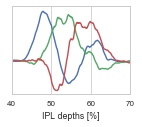

In [14]:
plt.figure(figsize=(5.4/2.54,4/2.54))
sns.set(font='Arial',style='whitegrid',context='paper')
plt.plot(np.linspace(-17.423,119.651,3576),density_PCA.components_.T)
plt.xlim(40,70)
plt.xticks([40,50,60,70])
plt.xlabel('IPL depths [%]')
plt.yticks([])
# plt.savefig('figures/type5_PCA.svg',bbox_inches='tight',dpi=300,transparent=True)
plt.show()

In [15]:
cbc5_params=density_PCA.transform(cbc5_volume_density2.T)

In [16]:
cbc5_GMM=GMM(n_components=3,random_state=198734)
cbc5_GMM.fit(cbc5_params)
cbc5_prediction=cbc5_GMM.predict(cbc5_params)

In [17]:
cbc5_prediction=cbc5_GMM.predict(cbc5_params)

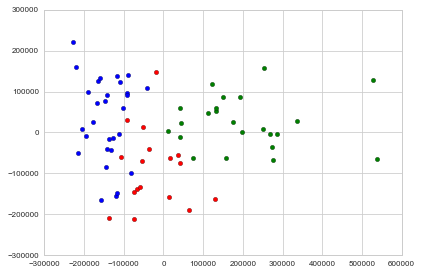

In [18]:
plt.scatter(cbc5_params[cbc5_prediction==0,0],cbc5_params[cbc5_prediction==0,2],c='b')
plt.scatter(cbc5_params[cbc5_prediction==1,0],cbc5_params[cbc5_prediction==1,2],c='g')
plt.scatter(cbc5_params[cbc5_prediction==2,0],cbc5_params[cbc5_prediction==2,2],c='r')
plt.show()

In [19]:
def eval_IPL_overlap(prediction):
    current_overlap_IPL=np.zeros(69)
    for i in range(69):
        current_overlap_IPL[i]=np.sum(overlaps_IPL[((overlaps_IPL[:,0]==i+390+144)&(prediction[overlaps_IPL[:,1].astype(int)-390-144]==prediction[i]))\
                        |((overlaps_IPL[:,1]==i+390+144)&(prediction[overlaps_IPL[:,0].astype(int)-390-144]==prediction[i])),2])
    current_overlap_IPL/=cbc5_ipl_area
    return(current_overlap_IPL)

In [20]:
def eval_OPL_overlap(prediction):
    current_overlap_OPL=np.zeros(69)
    for i in range(69):
        current_overlap_OPL[i]=np.sum(overlaps_OPL[((overlaps_OPL[:,0]==i+390+144)&(prediction[overlaps_OPL[:,1].astype(int)-390-144]==prediction[i]))\
                        |((overlaps_OPL[:,1]==i+390+144)&(prediction[overlaps_OPL[:,0].astype(int)-390-144]==prediction[i])),2])
    current_overlap_OPL/=cbc5_opl_area
    return(current_overlap_OPL)

In [21]:
def eval_clustering_GMM(prediction):
    distances_to_means=np.zeros(69)
    for i in range(69):
        distances_to_means[i]=np.sqrt(np.dot(cbc5_params[i,:]-cbc5_GMM.means_[prediction[i],:],\
                                     np.dot(np.diag(1/cbc5_GMM.covars_[prediction[i],:]),cbc5_params[i,:]-cbc5_GMM.means_[prediction[i],:])))
    return(np.sum(distances_to_means))

In [22]:
l1=1;l2=1.5;l3=1.5

In [23]:
cbc5_ipl_area,overlaps_IPL=calculate_overlap((BC_IDs[:,3]>62)&(BC_IDs[:,3]<66),'IPL')
cbc5_opl_area,overlaps_OPL=calculate_overlap((BC_IDs[:,3]>62)&(BC_IDs[:,3]<66),'OPL')

In [24]:
cbc5_overlap_opl=np.concatenate((overlaps_OPL,overlaps_OPL[:,[1,0,2]]))
cbc5_overlap_ipl=np.concatenate((overlaps_IPL,overlaps_IPL[:,[1,0,2]]))

In [25]:
num_iter=0
num_switches=0
switch_old=[]

while True:
    current_IPL_overlap=eval_IPL_overlap(cbc5_prediction)
    current_OPL_overlap=eval_OPL_overlap(cbc5_prediction)
    cost=l1*eval_clustering_GMM(cbc5_prediction)+l2*np.sum(current_IPL_overlap)+l3*np.sum(current_OPL_overlap)
    switch_array=np.argsort(current_IPL_overlap+current_OPL_overlap)
    switch_array=switch_array[np.in1d(switch_array,switch_old,invert=True)]
    switch=switch_array[-1]
    prediction_new=np.vstack((cbc5_prediction,cbc5_prediction))
    sorting=np.argsort(cbc5_GMM.score_samples(cbc5_params[switch,:].reshape(1,-1))[1][0])
    prediction_new[:,switch]=sorting[sorting!=cbc5_prediction[switch]]
    if l1*eval_clustering_GMM(prediction_new[0,:])+l2*np.sum(eval_IPL_overlap(prediction_new[0,:]))+l3*np.sum(eval_OPL_overlap(prediction_new[0,:]))<cost:
        cbc5_prediction=np.copy(prediction_new[0,:])
        switch_old=[]
        num_switches+=1
    elif l1*eval_clustering_GMM(prediction_new[1,:])+l2*np.sum(eval_IPL_overlap(prediction_new[1,:]))+l3*np.sum(eval_OPL_overlap(prediction_new[1,:]))<cost:
        cbc5_prediction=np.copy(prediction_new[1,:])
        switch_old=[]
        num_switches+=1
    else:
        new_overlaps=cbc5_overlap_ipl[(cbc5_overlap_ipl[:,0]==switch+390+144)&np.in1d(cbc5_overlap_ipl[:,1],np.where(cbc5_prediction==prediction_new[0,switch])[0]+390+144)]
        new_overlaps[:,2]+=cbc5_overlap_opl[(cbc5_overlap_opl[:,0]==switch+390+144)&np.in1d(cbc5_overlap_opl[:,1],np.where(cbc5_prediction==prediction_new[0,switch])[0]+390+144),2]
        new_overlaps[new_overlaps[:,2]==np.max(new_overlaps[:,2]),1][0]
        prediction_swap=prediction_new[0,:]
        prediction_swap[new_overlaps[new_overlaps[:,2]==np.max(new_overlaps[:,2]),1][0].astype(int)-390-144]=cbc5_prediction[switch]
        if l1*eval_clustering_GMM(prediction_swap)+l2*np.sum(eval_IPL_overlap(prediction_swap))+l3*np.sum(eval_OPL_overlap(prediction_swap))<cost:
            cbc5_prediction=np.copy(prediction_swap)
            switch_old=[]
            num_switches+=1
        else:
            new_overlaps=cbc5_overlap_ipl[(cbc5_overlap_ipl[:,0]==switch+390+144)&np.in1d(cbc5_overlap_ipl[:,1],np.where(cbc5_prediction==prediction_new[1,switch])[0]+390+144)]
            new_overlaps[:,2]+=cbc5_overlap_opl[(cbc5_overlap_opl[:,0]==switch+390+144)&np.in1d(cbc5_overlap_opl[:,1],np.where(cbc5_prediction==prediction_new[1,switch])[0]+390+144),2]
            new_overlaps[new_overlaps[:,2]==np.max(new_overlaps[:,2]),1][0]
            prediction_swap=prediction_new[1,:]
            prediction_swap[new_overlaps[new_overlaps[:,2]==np.max(new_overlaps[:,2]),1][0].astype(int)-390-144]=cbc5_prediction[switch]
            if l1*eval_clustering_GMM(prediction_swap)+l2*np.sum(eval_IPL_overlap(prediction_swap))+l3*np.sum(eval_OPL_overlap(prediction_swap))<cost:
                cbc5_prediction=np.copy(prediction_swap)
                switch_old=[]
                num_switches+=1
            else:
                switch_old.append(switch)
    num_iter+=1
    if len(switch_old)==cbc5_prediction.shape[0]:
        break
print('iterations:',num_iter)
print('switches:',num_switches)

iterations: 174
switches: 13


In [26]:
CBC5T=BC_IDs[(BC_IDs[:,3]>62)&(BC_IDs[:,3]<66),0][cbc5_prediction==1]
CBC5O=BC_IDs[(BC_IDs[:,3]>62)&(BC_IDs[:,3]<66),0][cbc5_prediction==2]
CBC5I=BC_IDs[(BC_IDs[:,3]>62)&(BC_IDs[:,3]<66),0][cbc5_prediction==0]

In [27]:
BC_IDs[np.in1d(BC_IDs[:,0],CBC5T),4]=63
BC_IDs[np.in1d(BC_IDs[:,0],CBC5O),4]=64
BC_IDs[np.in1d(BC_IDs[:,0],CBC5I),4]=65

In [28]:
# np.savetxt('data/BC_IDs_new',BC_IDs)

#### Plot density distributions of the axon terminals of the new CBC5 subtypes (Supp. figure 7B)

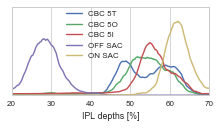

In [29]:
plt.figure(figsize=(9/2.54,4/2.54))
sns.set(font='Arial',style='whitegrid',context='paper')
plt.plot(np.linspace(-17.423,119.651,3576),np.sum(cbc5_volume_density[:,cbc5_prediction==1],axis=1)/np.sum(cbc5_volume_density[:,cbc5_prediction==1]),label='CBC 5T')
plt.plot(np.linspace(-17.423,119.651,3576),np.sum(cbc5_volume_density[:,cbc5_prediction==2],axis=1)/np.sum(cbc5_volume_density[:,cbc5_prediction==2]),label='CBC 5O')
plt.plot(np.linspace(-17.423,119.651,3576),np.sum(cbc5_volume_density[:,cbc5_prediction==0],axis=1)/np.sum(cbc5_volume_density[:,cbc5_prediction==0]),label='CBC 5I')
plt.plot(np.linspace(-17.423,119.651,3576),np.sum(off_sac_volume_density,axis=1)/np.sum(off_sac_volume_density[700:,:]),label='OFF SAC')
plt.plot(np.linspace(-17.423,119.651,3576),np.sum(on_sac_volume_density,axis=1)/np.sum(on_sac_volume_density[:2300,:]),label='ON SAC')
plt.xlabel('IPL depths [%]')
plt.yticks([])
plt.xlim(20,70)
plt.legend(bbox_to_anchor=(0.6, 1.05))
# plt.savefig('figures/type5_profiles.svg',bbox_inches='tight',dpi=300,transparent=True)
plt.show()

#### Plot dendritic and axonal mosaics of the new CBC5 subtypes (Supp. figure 7C)

In [ ]:
#5T
plot_mosaic(CBC5T-390,'IPL')
plot_mosaic(CBC5T-390,'OPL')

In [ ]:
#5O
plot_mosaic(np.where(cbc5_prediction==2)[0]+144,'IPL')
plot_mosaic(CBC5O-390,'OPL')

In [ ]:
#5I
plot_mosaic(CBC5T-390,'IPL')
plot_mosaic(CBC5I-390,'OPL')

#### Function definitions

In [2]:
def calculate_overlap(selection,layer):
    total_nodes=np.empty((0,2))
    polygons=[]
    for cell in BC_IDs[selection,0]:
        nodes_cell=np.empty((0,3))
        for skel in np.where(skeleton_ids==cell)[0]:
            nodes=skeletons[skel].item()[list(skeletons[skel].dtype.names).index('nodes')][:,:3]/[16.5,16.5,25]
            if nodes.shape[0]<2:
                continue
            nodes=np.dot(M,nodes.T).T
            edges=skeletons[skel].item()[list(skeletons[skel].dtype.names).index('edges')]
            soma_pos_cell=soma_positions[BC_IDs[:,0]==cell,0]*16.5
            if layer=='OPL':
                nodes=(nodes*[16.5,16.5,25]+[0,3250,15000]).astype(int)
                nodes_cell=np.concatenate((nodes_cell,nodes[nodes[:,0]<soma_pos_cell,0:3]),axis=0)
            elif layer=='IPL':
                nodes=(nodes*[16.5,16.5,25]+[0,5000,19000]).astype(int)
                nodes_cell=np.concatenate((nodes_cell,nodes[nodes[:,0]>soma_pos_cell,0:3]),axis=0)
            else:
                print("Layer has to be 'IPL' or 'OPL'")
                return([],[])
        if nodes_cell.shape[0]>2:
            nodes_cell=nodes_cell[:,1:]/[25,25]
            total_nodes=np.concatenate((total_nodes,nodes_cell),axis=0)
            hull=ConvexHull(nodes_cell)
            polygons.append(Polygon(nodes_cell[hull.vertices,:]))
    hull=ConvexHull(total_nodes)
    overlaps=[]
    area=[]
    for i in range(len(polygons)):
        area.append(polygons[i].area)
        for j in range(i+1,len(polygons)):
            overlaps.append([BC_IDs[selection,0][i],BC_IDs[selection,0][j],polygons[i].intersection(polygons[j]).area])
    overlaps=np.array(overlaps)
    area=np.array(area)
    return(area,overlaps)

In [3]:
def plot_mosaic(selection,layer='OPL'):
    im=Image.new('RGBA',(4800,3600),(255,255,255,0))
    draw = ImageDraw.Draw(im)
    draw.line([(0,0),(0,3599)],fill=(0,0,255,255),width=1)
    draw.line([(0,3599),(4799,3599)],fill=(0,0,255,255),width=1)
    draw.line([(4799,3599),(4799,0)],fill=(0,0,255,255),width=1)
    draw.line([(4799,0),(0,0)],fill=(0,0,255,255),width=1)
    del draw
    for cell in BC_IDs[selection,0]:
        nodes_cell=np.empty((0,3))
        for skel in np.where(skeleton_ids==cell)[0]:
            nodes=skeletons[skel].item()[list(skeletons[skel].dtype.names).index('nodes')][:,:3]/[16.5,16.5,25]
            if nodes.shape[0]<2:
                continue
            nodes=np.dot(M,nodes.T).T
            edges=skeletons[skel].item()[list(skeletons[skel].dtype.names).index('edges')]
            soma_pos_cell=soma_positions[BC_IDs[:,0]==cell,0]*16.5
            draw = ImageDraw.Draw(im)
            if layer=='OPL':
                nodes=(nodes*[16.5,16.5,25]+[0,3250,15000]).astype(int)
                for i in range(edges.shape[0]):
                    if (nodes[edges[i,0]-1,0]<soma_pos_cell) and (nodes[edges[i,1]-1,0]<soma_pos_cell):
                        draw.line([tuple(nodes[edges[i,0]-1,1:3]/[25,25]),tuple(nodes[edges[i,1]-1,1:3]/[25,25])],fill=(0,0,0,150),width=5)
                del draw
                nodes=nodes[np.unique(edges).astype(int)-1,:]
                nodes_cell=np.concatenate((nodes_cell,nodes[nodes[:,0]<soma_pos_cell,0:3]),axis=0)
            elif layer=='IPL':
                nodes=(nodes*[16.5,16.5,25]+[0,5000,19000]).astype(int)
                for i in range(edges.shape[0]):
                    if (nodes[edges[i,0]-1,0]>soma_pos_cell) and (nodes[edges[i,1]-1,0]>soma_pos_cell):
                        draw.line([tuple(nodes[edges[i,0]-1,1:3]/[25,25]),tuple(nodes[edges[i,1]-1,1:3]/[25,25])],fill=(0,0,0,150),width=5)
                del draw
                nodes=nodes[np.unique(edges).astype(int)-1,:]
                nodes_cell=np.concatenate((nodes_cell,nodes[nodes[:,0]>soma_pos_cell,0:3]),axis=0)
            else:
                print("Layer has to be 'IPL' or 'OPL'")
                return im
        if nodes_cell.shape[0]>2:
            nodes_cell=nodes_cell[:,1:]/[25,25]
            hull=ConvexHull(nodes_cell)
            draw = ImageDraw.Draw(im)
            for simplex in hull.simplices:
                draw.line([tuple(nodes_cell[simplex[0],:]),tuple(nodes_cell[simplex[1],:])],fill=(0,0,255,255),width=5)
            del draw
    plt.figure(figsize=(15,15))
    plt.imshow(im)